In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset as Dataset
from torch.optim import SGD, Adam
from skimage import io
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import os
import sys
import glob
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def imgLabelToClassLabel(thisLabel): #Either 1, 2, or 4
        label = 0
        if int(thisLabel) == int(2): ##gray matter 
            label = int(2)
        if int(thisLabel) == int(4): ##white matter
            label = int(1)
        if int(thisLabel) == int(1): ##background!
            label = int(0)
        return label
    
##Patches are 256x256
PATCH_SIZE = 3
IMG_HEIGHT = PATCH_SIZE*256
IMG_WIDTH  = PATCH_SIZE*256

CLASS_NAMES_STR = np.array(['bg', 'wm', 'gm'])
CLASS_NAMES  = np.array([0, 1, 2])


In [3]:
class PatchedNeighbourDataset(Dataset):
  # Inputs:
  # path - string containing path to a directroy of brain dataset image
  # transform - a transform to be done on the image; defaults to none if
  # no transforms are needed
    def __init__(self,path,transform = None):
 
        self.path = path
        self.transform = transform
        self.imageList = glob.glob(self.path+"/*/*.png")
        self._patch_per_side = 3
        self._grid_size = self._patch_per_side * self._patch_per_side
        self._patch_size = 256
        self._crop_size = 224

  # Retrieves image at specified index and returns the image along with a label
  # Inputs: 
  # idx - specified image index
  # Outputs:
  # sample - structures containing images and their corresponding labels
    def __getitem__(self,idx):
        img_fullpath = self.imageList[idx]
        img_name = img_fullpath.split("/")[-1]
        image = Image.open(img_fullpath)
#         print(img_name.split('.')[0])
        # Add label
        x, y, labels = img_name.split('.')[0].split('_')
        labels = list(map(int, list(labels)))
        labels = list(map(imgLabelToClassLabel, labels))
        neighbours = np.array([labels[0],  labels[1],  labels[2],
                      labels[3], labels[4], labels[5],
                      labels[6], labels[7], labels[8]])
        label = labels[4]


        #Crop to 3x3 grid
        w, h = image.size
        
        if self.transform:
            image = self.transform(image)
            image = np.array(image, dtype=np.float32).transpose((0, 1, 2))
            
            #flatten it -- maybe change crop_size back to 256?
            img_flat = np.zeros(
            (self._grid_size, 3, self._crop_size, self._crop_size),
            dtype=np.float32)
            
            ### This part is from the NCRF code
            idx = 0
            for x_idx in range(self._patch_per_side):
                for y_idx in range(self._patch_per_side):
                    # center crop each patch
                    x_start = int(
                        (x_idx + 0.5) * self._patch_size - self._crop_size / 2)
                    x_end = x_start + self._crop_size
                    y_start = int(
                        (y_idx + 0.5) * self._patch_size - self._crop_size / 2)
                    y_end = y_start + self._crop_size
                    img_flat[idx] = image[:, x_start:x_end, y_start:y_end]

                    idx += 1
            image = img_flat

        sample = {'image':image, 'label':label, 
                  'coords': (x,y), 'neighbours':neighbours}    
        return sample
  
  # Return the number of images in the dataset
    def __len__(self):
        return len(self.imageList)
  
  # Plot and visualize an image and its corresponding label
    def visualize(self,idx):
        img_fullpath = self.imageList[idx]
        image = io.imread(img_fullpath)
        img_name = img_fullpath.split("/")[-1]
#         print('Full Path:',img_fullpath)
#         print('Image Name:',img_name)

        plt.imshow(image)
        plt.show

<class 'int'>
110930 99837 11093


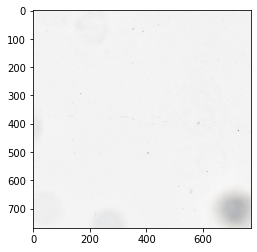

In [4]:
path = '/BrainSeg/3_3_dataset/'
brain = PatchedNeighbourDataset(path)
brain.visualize(32)
sample1 = brain.__getitem__(1)
print(type(sample1['label']))
SIZE = brain.__len__()
VAL_RATIO = 0.1
VAL_SIZE = int(SIZE * VAL_RATIO)
TRAIN_SIZE = SIZE - VAL_SIZE
print(SIZE, TRAIN_SIZE, VAL_SIZE) 

In [5]:
NORM_PATH = '/BrainSeg/normalization.npy'
norm = np.load(NORM_PATH,allow_pickle=True).item()
print(norm)

{'mean': array([0.77906426, 0.74919518, 0.77529276]), 'std': array([0.13986633, 0.15931302, 0.17665639])}


In [6]:
def Load_Train_Val(PATH_DIR, TRAIN_SIZE, VAL_SIZE, batch_size):
    # PATH = '/content/drive/My Drive/brain training/training_dataset'
    Train_Dataset = PatchedNeighbourDataset(PATH_DIR,
    #                             train = True,
                              transform = transforms.Compose([
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomVerticalFlip(),
                              transforms.RandomRotation(180),
                              transforms.ColorJitter(brightness=0.1, contrast=0.2,saturation=0.2, hue=0.02),
                              transforms.RandomAffine(0, translate=(0.05,0.05), scale=(0.9,1.1), shear=10),
                              transforms.ToTensor(),
                              transforms.Normalize(norm['mean'], norm['std'])
                              ]))
    #   train_data, val_data = torch.utils.data.dataset.random_split(Train_Dataset, (TRAIN_SIZE, VAL_SIZE))
    train_data, val_data = torch.utils.data.random_split(Train_Dataset, (TRAIN_SIZE, VAL_SIZE))
    print('The size of train data: ', len(train_data))
    print('The size of val data: ', len(val_data))
    #   print(len(train_data))
    train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size = batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size = batch_size, shuffle=True)
    return train_loader, val_loader

In [7]:
train_loader, val_loader = Load_Train_Val(path, TRAIN_SIZE, VAL_SIZE, batch_size = 8)

The size of train data:  99837
The size of val data:  11093


In [8]:
import torch
from torch import nn
### comments starting with "###" are my (Toluwa's) notes

class CRF(nn.Module):
    def __init__(self, num_nodes, iteration=10):
        """Initialize the CRF module
        Args:
            num_nodes: int, number of nodes/patches within the fully CRF
            iteration: int, number of mean field iterations, e.g. 10
        """
        super(CRF, self).__init__()
        self.num_nodes = num_nodes
        self.iteration = iteration
        self.W = nn.Parameter(torch.zeros(1, num_nodes, num_nodes))

    def forward(self, feats, logits):
        """Performing the CRF. Algorithm details is explained below:
        Within the paper, I formulate the CRF distribution using negative
        energy and cost, e.g. cosine distance, to derive pairwise potentials
        following the convention in energy based models. But for implementation
        simplicity, I use reward, e.g. cosine similarity to derive pairwise
        potentials. So now, pairwise potentials would encourage high reward for
        assigning (y_i, y_j) with the same label if (x_i, x_j) are similar, as
        measured by cosine similarity, pairwise_sim. For
        pairwise_potential_E = torch.sum(
            probs * pairwise_potential - (1 - probs) * pairwise_potential,
            dim=2, keepdim=True
        )
        This is taking the expectation of pairwise potentials using the current
        marginal distribution of each patch being tumor, i.e. probs. There are
        four cases to consider when taking the expectation between (i, j):
        1. i=T,j=T; 2. i=N,j=T; 3. i=T,j=N; 4. i=N,j=N
        probs is the marginal distribution of each i being tumor, therefore
        logits > 0 means tumor and logits < 0 means normal. Given this, the
        full expectation equation should be:
        [probs * +pairwise_potential] + [(1 - probs) * +pairwise_potential] +
                    case 1                            case 2
        [probs * -pairwise_potential] + [(1 - probs) * -pairwise_potential]
                    case 3                            case 4
        positive sign rewards logits to be more tumor and negative sign rewards
        logits to be more normal. But because of label compatibility, i.e. the
        indicator function within equation 3 in the paper, case 2 and case 3
        are dropped, which ends up being:
        probs * pairwise_potential - (1 - probs) * pairwise_potential
        In high level speaking, if (i, j) embedding are different, then
        pairwise_potential, as computed as cosine similarity, would approach 0,
        which then as no affect anyway. if (i, j) embedding are similar, then
        pairwise_potential would be a positive reward. In this case,
        if probs -> 1, then pairwise_potential promotes tumor probability;
        if probs -> 0, then -pairwise_potential promotes normal probability.
        Args:
            feats: 3D tensor with the shape of
            [batch_size, num_nodes, embedding_size], where num_nodes is the
            number of patches within a grid, e.g. 9 for a 3x3 grid;
            embedding_size is the size of extracted feature representation for
            each patch from ResNet, e.g. 512
            logits: 3D tensor with shape of [batch_size, num_nodes, 1], the
            logit of each patch within the grid being tumor before CRF
        Returns:
            logits: 3D tensor with shape of [batch_size, num_nodes, 1], the
            logit of each patch within the grid being tumor after CRF
        """
        ###We can formulate the above as 0 for bg
        ###0.5 for white matter, 1 for grey matter
        ###p=2 means nuclear norm
        #print("input logits are with shape", logits, logits.shape)
        feats_norm = torch.norm(feats, p=2, dim=2, keepdim=True)
        pairwise_norm = torch.bmm(feats_norm,
                                  torch.transpose(feats_norm, 1, 2))
        pairwise_dot = torch.bmm(feats, torch.transpose(feats, 1, 2))
        # cosine similarity between feats
        pairwise_sim = pairwise_dot / pairwise_norm
        # symmetric constraint for CRF weights
        W_sym = (self.W + torch.transpose(self.W, 1, 2)) / 2
        pairwise_potential = pairwise_sim * W_sym
        unary_potential = logits.clone()

        for i in range(self.iteration):
            # current Q after normalizing the logits
            ###probs = torch.transpose(logits.sigmoid(), 1, 2)
            #print("logits before", logits.shape, pairwise_potential.shape)
            probs = torch.transpose(logits.softmax(2, torch.float32), 1, 2)
            #print("logits now", probs, probs.shape, pairwise_potential.shape)
            
            # taking expectation of pairwise_potential using current Q
            ###Toluwa - this may need updating because original was formulated assuming there were only 2 classes
            
            ##Probability that it belongs to class 0
            pairwise_potential_E0 = torch.sum(
                probs[:,0:1,:] * pairwise_potential - (1 - probs[:,0:1,:]) * pairwise_potential,
                dim=2, keepdim=True)
            
            ##Probability that it belongs to class 1
            pairwise_potential_E1 = torch.sum(
            probs[:,1:2,:] * pairwise_potential - (1 - probs[:,0:1,:]) * pairwise_potential,
            dim=2, keepdim=True)
            
            ##Probability that it belongs to class 2          
            pairwise_potential_E2 = torch.sum(
            probs[:,2:,:] * pairwise_potential - (1 - probs[:,0:1,:]) * pairwise_potential,
            dim=2, keepdim=True)
            
            pairwise_potential_E = torch.cat((pairwise_potential_E0, pairwise_potential_E1), 2)
            pairwise_potential_E = torch.cat((pairwise_potential_E, pairwise_potential_E2), 2)
            
            #print("unary potential has shape", unary_potential.shape, pairwise_potential_E.shape)
            logits = unary_potential + pairwise_potential_E

        #print("Logits shape is", logits.shape, logits)
        return logits

    def __repr__(self):
        return 'CRF(num_nodes={}, iteration={})'.format(
            self.num_nodes, self.iteration
        )

In [9]:
import torch
import torch.nn as nn
import math

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=3, num_nodes=1,
                 use_crf=True):
        """Constructs a ResNet model.
        Args:
            num_classes: int, since we are doing binary classification
                (tumor vs normal), num_classes is set to 1 and sigmoid instead
                of softmax is used later
            num_nodes: int, number of nodes/patches within the fully CRF
            use_crf: bool, use the CRF component or not
        """
        ###Jokes, we're NOT doing binary classification so modify this for multi-classification
        ###Mainly we're doing softmax and setting num_classes to 3

        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        #print("Model debug block", block, block.expansion)
        self.crf = CRF(num_nodes) if use_crf else None

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Args:
            x: 5D tensor with shape of
            [batch_size, grid_size, 3, crop_size, crop_size],
            where grid_size is the number of patches within a grid (e.g. 9 for
            a 3x3 grid); crop_size is 224 by default for ResNet input;
        Returns:
            logits, 2D tensor with shape of [batch_size, grid_size], the logit
            of each patch within the grid being tumor
        """
        #print("X shape is", x.shape)
        batch_size, grid_size, _, crop_size = x.shape[0:4]
        # flatten grid_size dimension and combine it into batch dimension
        x = x.view(-1, 3, crop_size, crop_size)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        # feats means features, i.e. patch embeddings from ResNet
        feats = x.view(x.size(0), -1)
        #print("feats shape", feats.shape, feats[0].shape)
        #print("feats are", feats)

        logits = self.fc(feats)

        # restore grid_size dimension for CRF
        feats = feats.view((batch_size, grid_size, -1))
        logits = logits.view((batch_size, grid_size, -1))

        if self.crf:
            logits = self.crf(feats, logits)
            
        #print("Final logits shape before squeezeis ", logits.shape, logits)

        logits = torch.squeeze(logits)
        ##Toluwa adding this to return which class we're picking
        ##print("Final logits shape is ", logits.shape, logits)
        #_, logits = torch.max(logits, 2)
        #print("Final logits shape 2 is", logits.shape, logits)
        return logits


def resnet18(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

    return model


def resnet34(**kwargs):
    """Constructs a ResNet-34 model.
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)

    return model


def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)

    return model


def resnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)

    return model


def resnet152(**kwargs):
    """Constructs a ResNet-152 model.
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)

    return model

In [10]:
MODELS = {'resnet18': resnet18,
          'resnet34': resnet34,
          'resnet50': resnet50,
          'resnet101': resnet101,
          'resnet152': resnet152}

In [11]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [12]:
def patched_crf_train(model, loss_func, optimizer, lr_scheduler, num_epochs, PATH, train_loader, val_loader, number):
    model.train()
    tcorrect = 0
    ttotal = 0
    ###print("Just got into patched_crf\n\n")
    for epoch in range(num_epochs):
        print("Epoch %d/%d" % (epoch, num_epochs))
        start = time.time()
        running_loss = 0.0
        for i, data in enumerate(train_loader,0):
            inputs = data['image']
            labels = data['label']
#             neighbours = data['neighbours']
            inputs, labels = Variable(inputs), Variable(labels)
#             neighbours = Variable(neighbours)
            inputs = inputs.cuda()
#             neighbours = neighbours.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            print('outputs:',outputs)
#             print('outputs:', outputs)
            #print("Final output shapes", outputs.shape, neighbours.shape)
            current_p = outputs[:, 4, 0]
#             current_p = outputs[:, 4, 0]
            print('current_p:',current_p)
            outputs = outputs.permute(0, 2, 1)
#             print(neighbours[:,4])
#             loss = loss_func(outputs, neighbours)
#             loss = loss_func(current_p, labels)
            loss = loss_func(outputs[:, 4, :], neighbours[:,4])
        
            ###Backwards propagation
            loss.backward()
            optimizer.step()
            running_loss += float(loss.item())

            
            ###Print status
            if i % 400 == 399:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0
                
            _, current_p = torch.max(current_p.data, 1)

            ttotal += neighbours.size(0)
#             tcorrect += (neighbours[:,4] == current_p).sum().item()
            tcorrect += (labels == current_p).sum().item()
 
        print('\tAccuracy = %.6f' % (100 * tcorrect / ttotal))

        end = time.time()
        print("Train Time:", end-start)
        print("Traing finished", epoch+1, "epochs")

        model_name = 'PatchedCRF_3x3_'
        MODEL_PATH_1 = PATH + '/' + model_name + str(number) + '.pkl'
        
        torch.save(model, MODEL_PATH_1)
        number = number + 1

    ###get some stats on the values
        correct = 0
        total = 0
        val_loss = 0.0
        window = 200
        model.eval()
        start = time.time()

        for i_val, data_val in enumerate(val_loader,0):
            img_val = data_val['image']
            label_val = data_val['label']
            neigh_val = data_val['neighbours']


            #print("Image shape is", img_val.shape)

            img_val, label_val = Variable(img_val), Variable(label_val)
            neigh_val = Variable(neigh_val)
            img_val = img_val.cuda()
            neigh_val = neigh_val.cuda()

            predict = model(img_val)
            
#             predict = predict.permute(0, 2, 1)

#             loss_val = loss_func(predict, neigh_val)
#             loss_val = loss_func(predict[:, 4, :], neigh_val[:,4])
            loss = loss_func(outputs, labels)
            val_loss += loss_val.item()

            ###This is assuming we're using one hot encoding?
#             print("predict is of shape", predict.shape)
#             print("predict is of value", predict)
#             print("\n")
            predict = predict.permute(0, 2, 1)
            predict = predict[:, 4, :]
#             print("predict is now", predict)

            _, predict = torch.max(predict.data, 1)
#             print("predict is now", predict)
#             print("compared to", neigh_val[:,4])

#             print("neigh val size is", neigh_val.size(0))
            total += neigh_val.size(0)
            correct += (neigh_val[:,4] == predict).sum().item()
            if i_val % window == window-1:    # print every 2000 mini-batches
                print('[%5d] val_loss: %.3f' %
                        (i_val + 1, val_loss / window))
                val_loss = 0.0
        print('Accuracy = %.6f' % (100 * correct / total))
        end = time.time()
        print('val_time', end - start)

    print('Finished Training')
    torch.save(model, MODEL_PATH_1)

In [12]:
def patched_crf_train_2(model, loss_func, optimizer, lr_scheduler, num_epochs, PATH, train_loader, val_loader, number):
    model.train()
    tcorrect = 0
    ttotal = 0
    for epoch in range(num_epochs):
        print("Epoch %d/%d" % (epoch, num_epochs))
        start = time.time()
        running_loss = 0.0
        for i, data in enumerate(train_loader,0):
            inputs = data['image']
            labels = data['label']
            inputs, labels = Variable(inputs), Variable(labels)
            inputs = inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            current_p = outputs[:, 4, :]
            loss = loss_func(current_p, labels)
        
            ###Backwards propagation
            loss.backward()
            optimizer.step()
            running_loss += float(loss.item())

            
            ###Print status
            if i % 400 == 399:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0
                
            _, current_p = torch.max(current_p.data, 1)
            ttotal += labels.size(0)
            tcorrect += (labels == current_p).sum().item()
 
        print('\tAccuracy = %.6f' % (100 * tcorrect / ttotal))

        end = time.time()
        print("Train Time:", end-start)
        print("Traing finished", epoch+1, "epochs")

        model_name = 'PatchedCRF_3x3_'
        MODEL_PATH_1 = PATH + '/' + model_name + str(number) + '.pkl'
        
        torch.save(model, MODEL_PATH_1)
        number = number + 1

    ###get some stats on the values
        correct = 0
        total = 0
        val_loss = 0.0
        window = 200
        model.eval()
        start = time.time()

        for i_val, data_val in enumerate(val_loader,0):
            img_val = data_val['image']
            label_val = data_val['label']
            img_val, label_val = Variable(img_val), Variable(label_val)
            img_val = img_val.cuda()
            label_val = label_val.cuda()

            predict = model(img_val)
            loss_val = loss_func(predict[:, 4, :], label_val)
            val_loss += loss_val.item()

            ###This is assuming we're using one hot encoding?
#             print("predict is of shape", predict.shape)
#             print("predict is of value", predict)
#             print("\n")
#             predict = predict.permute(0, 2, 1)
            predict = predict[:, 4, :]

            _, predict = torch.max(predict.data, 1)

#             print("neigh val size is", neigh_val.size(0))
            total += label_val.size(0)
            correct += (label_val == predict).sum().item()
            if i_val % window == window-1:    # print every 2000 mini-batches
                print('[%5d] val_loss: %.3f' %
                        (i_val + 1, val_loss / window))
                val_loss = 0.0
        print('Accuracy = %.6f' % (100 * correct / total))
        end = time.time()
        print('val_time', end - start)

    print('Finished Training')
    torch.save(model, MODEL_PATH_1)

In [ ]:
model = torch.load('/BrainSeg/Codes/CRF/LF0811_Checkpoints/PatchedCRF_3x3_17.pkl')
PATH = '/BrainSeg/Codes/CRF/LF0811_Checkpoints'
lr_scheduler = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr_scheduler)
weight = torch.tensor([0.2,0.6,0.2]).cuda()
loss_func = nn.CrossEntropyLoss(weight=weight)
num_epochs = 2
number = 18
patched_crf_train_2(model, loss_func, optimizer, lr_scheduler, num_epochs, PATH, train_loader, val_loader, number)

Epoch 0/2
[1,   400] loss: 0.385
[1,   800] loss: 0.338
[1,  1200] loss: 0.379
[1,  1600] loss: 0.385
[1,  2000] loss: 0.359
[1,  2400] loss: 0.390
[1,  2800] loss: 0.329
[1,  3200] loss: 0.412
[1,  3600] loss: 0.340
[1,  4000] loss: 0.320
[1,  4400] loss: 0.360
[1,  4800] loss: 0.363
[1,  5200] loss: 0.355
[1,  5600] loss: 0.348
[1,  6000] loss: 0.324
[1,  6400] loss: 0.339
[1,  6800] loss: 0.357
[1,  7200] loss: 0.372
[1,  7600] loss: 0.362
[1,  8000] loss: 0.354
[1,  8400] loss: 0.369
[1,  8800] loss: 0.308
[1,  9200] loss: 0.355
[1,  9600] loss: 0.334
[1, 10000] loss: 0.376
[1, 10400] loss: 0.354
[1, 10800] loss: 0.372
[1, 11200] loss: 0.331
[1, 11600] loss: 0.365
[1, 12000] loss: 0.388
[1, 12400] loss: 0.360
	Accuracy = 94.627242
Train Time: 11659.168398618698
Traing finished 1 epochs
[  200] val_loss: 0.170
[  400] val_loss: 0.164
[  600] val_loss: 0.171
[  800] val_loss: 0.174
[ 1000] val_loss: 0.170
[ 1200] val_loss: 0.185
Accuracy = 94.762463
val_time 1207.1391713619232
Epoch 

In [13]:
PATH = '/BrainSeg/Checkpoints/new_LF/'
if not os.path.exists(PATH):
    os.makedirs(PATH)

BATCH_SIZE = 8
PATCH_SIZE = 3 

IMG_HEIGHT = PATCH_SIZE*256
IMG_WIDTH  = PATCH_SIZE*256
cfg = {
 "model": "resnet18",
 "use_crf": True,
 "batch_size": BATCH_SIZE,
 "image_size": IMG_HEIGHT,
 "patch_size": 256,
 "crop_size": 768,
 "lr": 0.0001,
 "momentum": 0.9,
 "epoch": 20,
 "log_every": 100
}


if cfg['image_size'] % cfg['patch_size'] != 0:
    raise Exception('Image size / patch size != 0 : {} / {}'.format(cfg['image_size'], cfg['patch_size']))

patch_per_side = cfg['image_size'] // cfg['patch_size']
grid_size = patch_per_side * patch_per_side
model = MODELS[cfg['model']](num_nodes=grid_size, use_crf=cfg['use_crf'])
model = model.cuda()
print("model is", model)
###we can't use BCEwithLogitsLoss since we're not doing binary classification
# loss_func = loss_func = nn.CrossEntropyLoss() #BCEWithLogitsLoss().cuda()

# optimizer = SGD(model.parameters(), lr=cfg['lr'], momentum=cfg['momentum'])

model is ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

In [ ]:
model = torch.load('/BrainSeg/Codes/CRF/LF0811_Checkpoints/PatchedCRF_3x3_21.pkl')
PATH = '/BrainSeg/Codes/CRF/LF0811_Checkpoints'
lr_scheduler = 0.00001
optimizer = optim.Adam(model.parameters(), lr=lr_scheduler)
# weight = torch.tensor([0.2,0.6,0.2]).cuda()
loss_func = nn.CrossEntropyLoss()
num_epochs = 2
number = 22
patched_crf_train_2(model, loss_func, optimizer, lr_scheduler, num_epochs, PATH, train_loader, val_loader, number)

Epoch 0/2
[1,   400] loss: 0.278
[1,   800] loss: 0.297
[1,  1200] loss: 0.274
[1,  1600] loss: 0.297
[1,  2000] loss: 0.282
[1,  2400] loss: 0.298
[1,  2800] loss: 0.247
[1,  3200] loss: 0.283
[1,  3600] loss: 0.300
[1,  4000] loss: 0.283
[1,  4400] loss: 0.280
[1,  4800] loss: 0.304
[1,  5200] loss: 0.276
[1,  5600] loss: 0.284
[1,  6000] loss: 0.279
[1,  6400] loss: 0.275
[1,  6800] loss: 0.279
[1,  7200] loss: 0.298
[1,  7600] loss: 0.294
[1,  8000] loss: 0.315
[1,  8400] loss: 0.302
[1,  8800] loss: 0.254
[1,  9200] loss: 0.275
[1,  9600] loss: 0.255
[1, 10000] loss: 0.283
[1, 10400] loss: 0.285
[1, 10800] loss: 0.289
[1, 11200] loss: 0.292
[1, 11600] loss: 0.290
[1, 12000] loss: 0.259
[1, 12400] loss: 0.277
	Accuracy = 95.380470
Train Time: 11745.0259308815
Traing finished 1 epochs
[  200] val_loss: 0.142
[  400] val_loss: 0.136
[  600] val_loss: 0.133
[  800] val_loss: 0.142
[ 1000] val_loss: 0.141
[ 1200] val_loss: 0.152
Accuracy = 95.456594
val_time 1203.5317358970642
Epoch 1/

In [ ]:
model = torch.load('/BrainSeg/Codes/CRF/Checkpoints/PatchedCRF_3x3_16.pkl')
PATH = '/BrainSeg/Codes/CRF/Checkpoints'
lr_scheduler = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr_scheduler)
loss_func = nn.CrossEntropyLoss()
num_epochs = 3
number = 17
patched_crf_train(model, loss_func, optimizer, lr_scheduler, num_epochs, PATH, train_loader, val_loader, number)

Epoch 0/3
[1,   400] loss: 0.379
[1,   800] loss: 0.392


In [ ]:
model = torch.load('/BrainSeg/Codes/CRF/Checkpoints/PatchedCRF_3x3_9.pkl')
# PATH = '/BrainSeg/Codes/CRF/Checkpoints'
lr_scheduler = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr_scheduler)
loss_func = nn.CrossEntropyLoss()
num_epochs = 3
number = 0
patched_crf_train(model, loss_func, optimizer, lr_scheduler, num_epochs, PATH, train_loader, val_loader, number)

Epoch 0/3
[1,   400] loss: 0.379
[1,   800] loss: 0.390
[1,  1200] loss: 0.364
[1,  1600] loss: 0.374
[1,  2000] loss: 0.416
[1,  2400] loss: 0.390
[1,  2800] loss: 0.345
[1,  3200] loss: 0.397
[1,  3600] loss: 0.399
[1,  4000] loss: 0.359
[1,  4400] loss: 0.375
[1,  4800] loss: 0.332
[1,  5200] loss: 0.375
[1,  5600] loss: 0.349
[1,  6000] loss: 0.376
	Accuracy = 95.598613
Train Time: 5603.756596088409
Traing finished 1 epochs
[  200] val_loss: 0.195
[  400] val_loss: 0.190
[  600] val_loss: 0.176
[  800] val_loss: 0.184
[ 1000] val_loss: 0.193
[ 1200] val_loss: 0.210
[ 1400] val_loss: 0.174
Accuracy = 95.650021
val_time 1286.0233166217804
Epoch 1/3
[2,   400] loss: 0.366
[2,   800] loss: 0.399
[2,  1200] loss: 0.379


In [16]:
model = torch.load('/BrainSeg/Codes/CRF/Checkpoints/PatchedCRF_3x3_15.pkl')
PATH = '/BrainSeg/Codes/CRF/Checkpoints'
lr_scheduler = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr_scheduler)
loss_func = nn.CrossEntropyLoss()
num_epochs = 2
number = 16
patched_crf_train(model, loss_func, optimizer, lr_scheduler, num_epochs, PATH, train_loader, val_loader, number)

Epoch 0/2
[1,   400] loss: 0.415
[1,   800] loss: 0.376
[1,  1200] loss: 0.382
[1,  1600] loss: 0.393
[1,  2000] loss: 0.395
[1,  2400] loss: 0.377
[1,  2800] loss: 0.386
[1,  3200] loss: 0.398
[1,  3600] loss: 0.358
[1,  4000] loss: 0.379
[1,  4400] loss: 0.370
[1,  4800] loss: 0.347
[1,  5200] loss: 0.338
[1,  5600] loss: 0.367
[1,  6000] loss: 0.369
[1,  6400] loss: 0.355
[1,  6800] loss: 0.364
[1,  7200] loss: 0.363
[1,  7600] loss: 0.333
[1,  8000] loss: 0.401
[1,  8400] loss: 0.368
[1,  8800] loss: 0.395
	Accuracy = 95.674025
Train Time: 9307.403129816055
Traing finished 1 epochs


/.local/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/.local/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/.local/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[  200] val_loss: 0.184
[  400] val_loss: 0.169
[  600] val_loss: 0.188
[  800] val_loss: 0.163
[ 1000] val_loss: 0.166
Accuracy = 96.188929
val_time 966.1874871253967
Epoch 1/2
[2,   400] loss: 0.352
[2,   800] loss: 0.334
[2,  1200] loss: 0.343
[2,  1600] loss: 0.378
[2,  2000] loss: 0.357
[2,  2400] loss: 0.358
[2,  2800] loss: 0.373
[2,  3200] loss: 0.368
[2,  3600] loss: 0.378
[2,  4000] loss: 0.398
[2,  4400] loss: 0.352
[2,  4800] loss: 0.338
[2,  5200] loss: 0.399
[2,  5600] loss: 0.326
[2,  6000] loss: 0.374
[2,  6400] loss: 0.348
[2,  6800] loss: 0.353
[2,  7200] loss: 0.348
[2,  7600] loss: 0.331
[2,  8000] loss: 0.358
[2,  8400] loss: 0.366
[2,  8800] loss: 0.394
	Accuracy = 95.746217
Train Time: 8498.527079343796
Traing finished 2 epochs
[  200] val_loss: 0.184
[  400] val_loss: 0.163
[  600] val_loss: 0.164
[  800] val_loss: 0.163
[ 1000] val_loss: 0.177
Accuracy = 96.363864
val_time 867.2376441955566
Finished Training


In [18]:
model = torch.load('/BrainSeg/Codes/CRF/Checkpoints/PatchedCRF_3x3_17.pkl')
PATH = '/BrainSeg/Codes/CRF/Checkpoints'
lr_scheduler = 0.00001
optimizer = optim.Adam(model.parameters(), lr=lr_scheduler)
loss_func = nn.CrossEntropyLoss()
num_epochs = 2
number = 18
patched_crf_train(model, loss_func, optimizer, lr_scheduler, num_epochs, PATH, train_loader, val_loader, number)

Epoch 0/2
[1,   400] loss: 0.370
[1,   800] loss: 0.367
[1,  1200] loss: 0.343
[1,  1600] loss: 0.377
[1,  2000] loss: 0.358
[1,  2400] loss: 0.375
[1,  2800] loss: 0.352
[1,  3200] loss: 0.364
[1,  3600] loss: 0.342
[1,  4000] loss: 0.369
[1,  4400] loss: 0.399
[1,  4800] loss: 0.348
[1,  5200] loss: 0.358
[1,  5600] loss: 0.379
[1,  6000] loss: 0.395
[1,  6400] loss: 0.350
[1,  6800] loss: 0.369
[1,  7200] loss: 0.374
[1,  7600] loss: 0.361
[1,  8000] loss: 0.373
[1,  8400] loss: 0.344
[1,  8800] loss: 0.343
	Accuracy = 95.846175
Train Time: 8466.553433895111
Traing finished 1 epochs
[  200] val_loss: 0.167
[  400] val_loss: 0.177
[  600] val_loss: 0.167
[  800] val_loss: 0.171
[ 1000] val_loss: 0.173
Accuracy = 96.213920
val_time 868.7083420753479
Epoch 1/2
[2,   400] loss: 0.353
[2,   800] loss: 0.366
[2,  1200] loss: 0.351
[2,  1600] loss: 0.339
[2,  2000] loss: 0.346
[2,  2400] loss: 0.350
[2,  2800] loss: 0.360
[2,  3200] loss: 0.358
[2,  3600] loss: 0.355
[2,  4000] loss: 0.351

In [ ]:
model = torch.load('/BrainSeg/Codes/CRF/Checkpoints/PatchedCRF_3x3_17.pkl')
PATH = '/BrainSeg/Codes/CRF/Checkpoints'
lr_scheduler = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr_scheduler)
weight = torch.tensor([0.2,0.6,0.2]).cuda()
loss_func = nn.CrossEntropyLoss(weight=weight)
loss_func = nn.CrossEntropyLoss()
num_epochs = 2
number = 0
patched_crf_train(model, loss_func, optimizer, lr_scheduler, num_epochs, PATH, train_loader, val_loader, number)

Epoch 0/2
[1,   400] loss: 0.353
[1,   800] loss: 0.363
[1,  1200] loss: 0.355
[1,  1600] loss: 0.327
[1,  2000] loss: 0.387
[1,  2400] loss: 0.340
[1,  2800] loss: 0.377
[1,  3200] loss: 0.365
[1,  3600] loss: 0.387
[1,  4000] loss: 0.368
[1,  4400] loss: 0.344
[1,  4800] loss: 0.367
[1,  5200] loss: 0.399
[1,  5600] loss: 0.339
[1,  6000] loss: 0.352
[1,  6400] loss: 0.380
[1,  6800] loss: 0.360
[1,  7200] loss: 0.361
[1,  7600] loss: 0.339
[1,  8000] loss: 0.341
[1,  8400] loss: 0.374
[1,  8800] loss: 0.394
[1,  9200] loss: 0.348
[1,  9600] loss: 0.366
[1, 10000] loss: 0.381
[1, 10400] loss: 0.328
[1, 10800] loss: 0.376
[1, 11200] loss: 0.328
[1, 11600] loss: 0.344
[1, 12000] loss: 0.353
[1, 12400] loss: 0.372
	Accuracy = 95.877280
Train Time: 27527.289432525635
Traing finished 1 epochs


/.local/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/.local/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/.local/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[  200] val_loss: 0.172
[  400] val_loss: 0.177
[  600] val_loss: 0.207
[  800] val_loss: 0.193
[ 1000] val_loss: 0.169
[ 1200] val_loss: 0.194
Accuracy = 95.654918
val_time 2844.5812129974365
Epoch 1/2
[2,   400] loss: 0.388
[2,   800] loss: 0.363
[2,  1200] loss: 0.320
[2,  1600] loss: 0.349
[2,  2000] loss: 0.383
[2,  2400] loss: 0.351
[2,  2800] loss: 0.336
[2,  3200] loss: 0.350
[2,  3600] loss: 0.356
[2,  4000] loss: 0.364
[2,  4400] loss: 0.343
[2,  4800] loss: 0.340
[2,  5200] loss: 0.331
[2,  5600] loss: 0.353
[2,  6000] loss: 0.338
[2,  6400] loss: 0.356
[2,  6800] loss: 0.326
[2,  7200] loss: 0.339
[2,  7600] loss: 0.375
[2,  8000] loss: 0.377
